In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


In [6]:
!pip install torch nibabel torchinfo 'monai[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 55.3 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 21.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 37.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 43.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━

In [9]:
pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 10.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torchinfo
from monai.losses import SSIMLoss

import zipfile
import random
import os

import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchmetrics.functional import structural_similarity_index_measure
from monai.metrics import DiceMetric
from tqdm import tqdm
import matplotlib.pyplot as plt

**Model : Unet**



In [41]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.4
).to(device)


In [42]:
torchinfo.summary(model, input_size=(8, 1, 16,  128,  128))

Layer (type:depth-idx)                                                                Output Shape              Param #
UNet                                                                                  [8, 1, 16, 128, 128]      --
├─Sequential: 1-1                                                                     [8, 1, 16, 128, 128]      --
│    └─ResidualUnit: 2-1                                                              [8, 16, 8, 64, 64]        --
│    │    └─Conv3d: 3-1                                                               [8, 16, 8, 64, 64]        448
│    │    └─Sequential: 3-2                                                           [8, 16, 8, 64, 64]        7,442
│    └─SkipConnection: 2-2                                                            [8, 32, 8, 64, 64]        --
│    │    └─Sequential: 3-3                                                           [8, 16, 8, 64, 64]        4,799,182
│    └─Sequential: 2-3                                          

##Dataset : openBHB Dataset

In [7]:
# # Path to the zip file in your Google Drive
# zip_file_path = '/content/drive/MyDrive/archive (9).zip'

# # Destination path to extract files
# destination_dir = '/content/dataset/'

# # Unzipping the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_dir)

# # List the extracted files (optional)
# os.listdir(destination_dir)


In [15]:
def split_data(source_dir, test_ratio=0.2, max_volumes=500):
    # Get a list of all volume files in the source directory
    volumes = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Limit to the first 400 volumes
    volumes = volumes[:max_volumes]

    # Shuffle volumes randomly
    random.shuffle(volumes)

    # Calculate the split index
    split_index = int(len(volumes) * (1 - test_ratio))

    # Split volumes into train and test sets
    train_volumes = volumes[:split_index]
    test_volumes = volumes[split_index:]

    return train_volumes, test_volumes

# Usage example:
source_dir = "/kaggle/input/openbhb/val_quasiraw"
test_ratio = 0.1  # Adjust this to change the test/train split

train_volumes, test_volumes = split_data(source_dir, test_ratio, max_volumes=600)


print("Training set volumes:", len(train_volumes))
print("Testing set volumes:", len(test_volumes))


Training set volumes: 540
Testing set volumes: 60


In [16]:
import os
import numpy as np
import torch

class BrainMRIDataset(Dataset):
    def __init__(self, base_path, volume_list, target_size=(88, 128, 128), slice_depth=16, transform=None):
        self.base_path = base_path
        self.volume_list = volume_list
        self.target_size = target_size
        self.slice_depth = slice_depth
        self.transform = transform

    def __len__(self):
        return len(self.volume_list)

    def crop(self, volume, start_y=20, end_y=160, start_x=20, end_x=196, start_z=50, end_z=130):
        cropped_volume = volume[start_z:end_z, start_y:end_y, start_x:end_x]
        return cropped_volume

    def get_slices(self, mri_volume):
        if len(mri_volume.shape) != 3:
            mri_volume = mri_volume.squeeze()

        patches = []
        num_slices = mri_volume.shape[0] // self.slice_depth

        for i in range(num_slices):
            start = i * self.slice_depth
            end = start + self.slice_depth
            patch = mri_volume[start:end, :, :]
            patches.append(patch)

        remainder = mri_volume.shape[0] % self.slice_depth
        if remainder > 0:
            patch = mri_volume[-self.slice_depth:, :, :]
            patches.append(patch)

        return patches

    def __getitem__(self, index):
        # Get the filename for the current volume
        volume_file = self.volume_list[index]

        # Construct the file path
        file_path = os.path.join(self.base_path, volume_file)

        # Load the .npy file
        mri_volume = np.load(file_path)  # Shape: (1, 1, 182, 218, 182)

        # Convert to tensor and remove redundant dimensions
        mri_volume = torch.tensor(mri_volume).float().squeeze().squeeze()  # Shape: [182, 218, 182]

        # (C, H, W, D ) - > (C, D, H, W)
        mri_volume = mri_volume.permute(2, 0, 1)

        # Crop to (80, 140, 176)
        mri_crop = self.crop(mri_volume)

        # Resize to target shape (128x128x128)
        mri_resize = F.interpolate(
            mri_crop.unsqueeze(0).unsqueeze(0),
            size=(mri_crop.shape[0], 128, 128),
            mode='trilinear',
            align_corners=False
        ).squeeze()

        # Normalize the volume
        mri_volume = (mri_resize - mri_resize.min()) / (mri_resize.max() - mri_resize.min() + 1e-8)

        # Slice the volume along the depth axis
        mri_slices = self.get_slices(mri_volume)

        # Add channel dimension back to each slice
        mri_slices = [slice.unsqueeze(0) for slice in mri_slices]  # Shape: [1, 128, 128, 8]

        return mri_slices


In [17]:
# Initialize dataset
dataset = BrainMRIDataset(base_path='/kaggle/input/openbhb/val_quasiraw', volume_list=train_volumes)

# Test the dataset
volume_slices = dataset[0]
print(f"Dataset length : {len(dataset)}, Number of slices: {len(volume_slices)}, Slice shape: {volume_slices[0].shape}")

Dataset length : 540, Number of slices: 5, Slice shape: torch.Size([1, 16, 128, 128])


In [18]:
class SliceDatasetFromList(Dataset):
    def __init__(self, patch_list):
        self.patch_list = [patch for sublist in patch_list for patch in sublist]

    def __len__(self):
        return len(self.patch_list)

    def __getitem__(self, index):
        patch = self.patch_list[index]
        patch_tensor = torch.tensor(patch).float()

        return patch_tensor, patch_tensor



In [19]:
Slices = SliceDatasetFromList(dataset)

train_ratio = 0.85
val_ratio = 0.15

train_size = int(train_ratio * len(Slices))
val_size = len(Slices) - train_size

train_dataset, val_dataset = random_split(Slices, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))


Train set size: 2295
Validation set size: 405


##Training

In [38]:
# import torch
# from monai.losses import PerceptualLoss

# # Initialize Perceptual Loss and SSIM Loss
# perceptual_loss_fn = PerceptualLoss(
#     spatial_dims=3,
#     network_type="medicalnet_resnet50_23datasets",
#     is_fake_3d=False,
#     pretrained=True
# )
# ssim_loss_fn = SSIMLoss(spatial_dims=3)

# # Send both loss functions to device
# perceptual_loss_fn = perceptual_loss_fn.to(device)
# ssim_loss_fn = ssim_loss_fn.to(device)

In [48]:
import torch
import torch.nn.functional as F

def multi_scale_loss(prediction, target, scales=[1, 0.5, 0.25], loss_fn=F.mse_loss):
    """
    Computes multi-scale loss between prediction and target.

    Args:
        prediction (torch.Tensor): The predicted output of the model.
        target (torch.Tensor): The ground truth target.
        scales (list): List of scales to downsample to (1 = original, 0.5 = half-size, etc.).
        loss_fn (callable): The loss function to use at each scale (e.g., MSE loss or MAE loss).

    Returns:
        torch.Tensor: Combined multi-scale loss.
    """
    total_loss = 0
    for scale in scales:
        # Downsample both prediction and target
        scaled_prediction = F.interpolate(prediction, scale_factor=scale, mode='trilinear', align_corners=False)
        scaled_target = F.interpolate(target, scale_factor=scale, mode='trilinear', align_corners=False)
        
        # Compute the loss at this scale
        loss = loss_fn(scaled_prediction, scaled_target)
        
        # Accumulate the loss
        total_loss += loss
    
    # Average the loss across scales
    return total_loss / len(scales)


In [21]:
# criterion = perceptual_loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [27]:
def save_checkpoint(state, is_best, checkpoint_dir="/kaggle/working/checkpoint_UNET_Resnet", filename="checkpoint_MSE_Perceptual.pth"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save(state, checkpoint_path)
    if is_best:
        best_model_path = os.path.join(checkpoint_dir, "best_model_MSE_Perceptual.pth")
        torch.save(state, best_model_path)
        print(f"Best model saved to {best_model_path}")


In [4]:
!pip install cloud-tpu-client==0.10 torch_xla==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 MB 10.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch_xla
    Found existing installation: torch-xla 2.1.0
    Uninstalling torch-xla-2.1.0:
      Successfully uninstalled torch-xla-2.1.0

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [43]:
print(device)

xla:0


In [24]:
import torch
import torch_xla.core.xla_model as xm
import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.xla_multiprocessing as xmp


In [35]:
device = xm.xla_device() 

In [30]:
device = xm.xla_device()
model = model.to(device)
imgs, targets = imgs.to(device), targets.to(device)


In [49]:
import torch
import monai
from monai.losses import PerceptualLoss, SSIMLoss
from tqdm import tqdm
import matplotlib.pyplot as plt

# Store training and validation losses
train_loss_values = []
val_loss_values = []

num_epochs = 50
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

def save_checkpoint(checkpoint, is_best):
    if is_best:
        torch.save(checkpoint, '/kaggle/working/checkpoint_UNET_Resnet/best_model.pth')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training loop
    for imgs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move inputs and targets to device
        optimizer.zero_grad()  # Clear gradients
        output = model(imgs)  # Forward pass
        
        # Calculate loss
        loss = multi_scale_loss(output, targets)
        
        # Backward pass
        loss.backward()
        xm.optimizer_step(optimizer)

        train_loss += loss.item()

    # Average training loss for this epoch
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
            imgs, targets = imgs.to(device), targets.to(device)
            output = model(imgs)  # Forward pass
            
            # Calculate loss
            loss = multi_scale_loss(output, targets)
            val_loss += loss.item()

    # Average validation loss for this epoch
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Print the losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        early_stop_counter = 0

        # Save the best model checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        save_checkpoint(checkpoint, is_best)
    else:
        early_stop_counter += 1

    # Early stopping condition
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
        break
        
    # Visualization of outputs every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:  # Sample from the validation set
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                break  # Get only the first batch

        depth = 8  # Adjust as needed for your data
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original Volume (Target)
        ax[0].imshow(targets[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Original Volume (Target)')
        ax[0].axis('off')

        # Reconstructed Volume (Output)
        ax[1].imshow(outputs[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Reconstructed Volume (Output)')
        ax[1].axis('off')

        plt.show()

# Print the best validation loss
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Plotting the loss
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation')

Epoch 1/50 (Training):   0%|          | 0/287 [00:00<?, ?it/s]


RuntimeError: torch_xla/csrc/aten_xla_bridge.cpp:105 : Check failed: xtensor 
*** Begin stack trace ***
	tsl::CurrentStackTrace()
	torch_xla::bridge::GetXlaTensor(at::Tensor const&)
	torch_xla::XLANativeFunctions::convolution_overrideable(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	
	
	c10::Dispatcher::callBoxed(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*) const
	
	
	at::_ops::convolution_overrideable::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	at::native::_convolution(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	
	
	at::functionalization::functionalize_op_helper(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*)
	at::functionalization::_functionalize_aten_op<at::_ops::_convolution, false, at::Tensor (at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt, bool, bool, bool, bool)>::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	torch_xla::XLANativeFunctions::_convolution(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long, bool, bool, bool, bool)
	
	
	at::_ops::_convolution::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt, bool, bool, bool, bool)
	at::native::convolution(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, c10::ArrayRef<long>, long)
	
	
	c10::Dispatcher::callBoxed(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*) const
	
	
	at::_ops::convolution::redispatch(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	
	at::_ops::convolution::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, bool, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	at::native::conv3d_symint(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	
	at::_ops::conv3d::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::ArrayRef<c10::SymInt>, c10::SymInt)
	
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	
	_PyEval_EvalFrameDefault
	
	
	
	
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	PyVectorcall_Call
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	
	
	
	
	
	
*** End stack trace ***
Input tensor is not an XLA tensor: torch.FloatTensor

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Epoch 24/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [24/50], Train Loss: 0.1517, Val Loss: 0.0473


Epoch 25/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [25/50], Train Loss: 0.1514, Val Loss: 0.0465


Epoch 26/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [26/50], Train Loss: 0.1514, Val Loss: 0.0463


Epoch 27/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [27/50], Train Loss: 0.1513, Val Loss: 0.0501


Epoch 28/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [28/50], Train Loss: 0.1510, Val Loss: 0.0534


Epoch 29/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [29/50], Train Loss: 0.1509, Val Loss: 0.0474


Epoch 30/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.63it/s]


Epoch [30/50], Train Loss: 0.1509, Val Loss: 0.0432


Epoch 31/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [31/50], Train Loss: 0.1506, Val Loss: 0.0430


Epoch 32/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [32/50], Train Loss: 0.1506, Val Loss: 0.0521


Epoch 33/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [33/50], Train Loss: 0.1504, Val Loss: 0.0478


Epoch 34/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [34/50], Train Loss: 0.1536, Val Loss: 0.0524


Epoch 35/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.64it/s]


Epoch [35/50], Train Loss: 0.1510, Val Loss: 0.0552


Epoch 36/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [36/50], Train Loss: 0.1505, Val Loss: 0.0468


Epoch 37/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.66it/s]


Epoch [37/50], Train Loss: 0.1502, Val Loss: 0.0529


Epoch 38/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.66it/s]


Epoch [38/50], Train Loss: 0.1504, Val Loss: 0.0494


Epoch 39/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [39/50], Train Loss: 0.1500, Val Loss: 0.0483


Epoch 40/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [40/50], Train Loss: 0.1499, Val Loss: 0.0468


Epoch 41/50 (Validation): 100%|██████████| 51/51 [00:06<00:00,  7.65it/s]


Epoch [41/50], Train Loss: 0.1499, Val Loss: 0.0507
Early stopping at epoch 41. No improvement in validation loss for 10 consecutive epochs.
Best Validation Loss: 0.0430


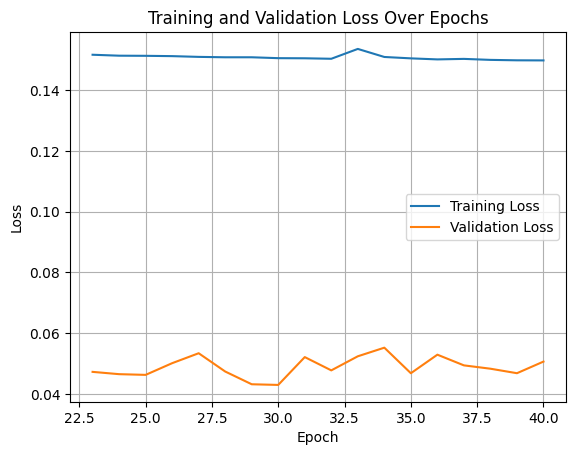

In [18]:
# # Load the checkpoint
# checkpoint_path = "/kaggle/input/checkpoint-ssim-2/checkpoint_epoch_best.pth"
# checkpoint = torch.load(checkpoint_path)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.load_state_dict(checkpoint['model_state_dict'])
# start_epoch = checkpoint.get('epoch', 0)  # Starting from the checkpointed epoch

# train_loss_values = []
# val_loss_values = []

# num_epochs = 50
# best_val_loss = float('inf')
# patience = 10
# early_stop_counter = 0

# # Training loop
# for epoch in range(start_epoch, num_epochs):
#     model.train()
#     train_loss = 0.0

#     for imgs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
#         imgs, targets = imgs.to(device), targets.to(device)
#         optimizer.zero_grad()  # Clear gradients
#         outputs = model(imgs)  # Forward pass
#         loss = criterion(outputs, targets)  # Compute loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update weights
#         train_loss += loss.item()

#     # Average training loss for this epoch
#     train_loss /= len(train_loader)
#     train_loss_values.append(train_loss)

#     # Validation loop
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
#             imgs, targets = imgs.to(device), targets.to(device)
#             outputs = model(imgs)  # Forward pass
#             loss = criterion(outputs, targets)  # Compute validation loss
#             val_loss += loss.item()

#     # Average validation loss for this epoch
#     val_loss /= len(val_loader)
#     val_loss_values.append(val_loss)

#     # Print the losses for this epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#     is_best = val_loss < best_val_loss
#     if is_best:
#         best_val_loss = val_loss
#         early_stop_counter = 0

#         # Save the best model checkpoint
#         checkpoint = {
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss
#         }
#         torch.save(checkpoint, '/kaggle/working/checkpoint_epoch_best.pth')
#     else:
#         early_stop_counter += 1

#     # Early stopping condition
#     if early_stop_counter >= patience:
#         print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
#         break
        


# # Print the best validation loss
# print(f"Best Validation Loss: {best_val_loss:.4f}")

# # Plotting the loss
# plt.plot(range(start_epoch, epoch + 1), train_loss_values, label='Training Loss')
# plt.plot(range(start_epoch, epoch + 1), val_loss_values, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.legend()
# plt.grid()
# plt.show()

In [19]:
# torch.save(model.state_dict(), '3d_MonaiUNET_slices_SSIM.pth')

In [44]:
dataset_test = BrainMRIDataset(base_path='/kaggle/input/openbhb/val_quasiraw', volume_list=test_volumes)

Slices_test = SliceDatasetFromList(dataset_test)

test_loader = DataLoader(Slices_test, batch_size=8)


In [7]:
checkpoint = torch.load("/kaggle/input/unet-mse-ssim/3d_MonaiUNET_slices_dense_SSIM_MSE.pth", weights_only=True)

# model = UNETR_Reconstruction(in_channels=1, img_size=(16, 128, 128), feature_size=32, norm_name='instance')
# model = model.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_unet = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)


model.eval()

print("Model loaded successfully.")


Model loaded successfully.


Testing:   0%|          | 0/38 [00:00<?, ?it/s]To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


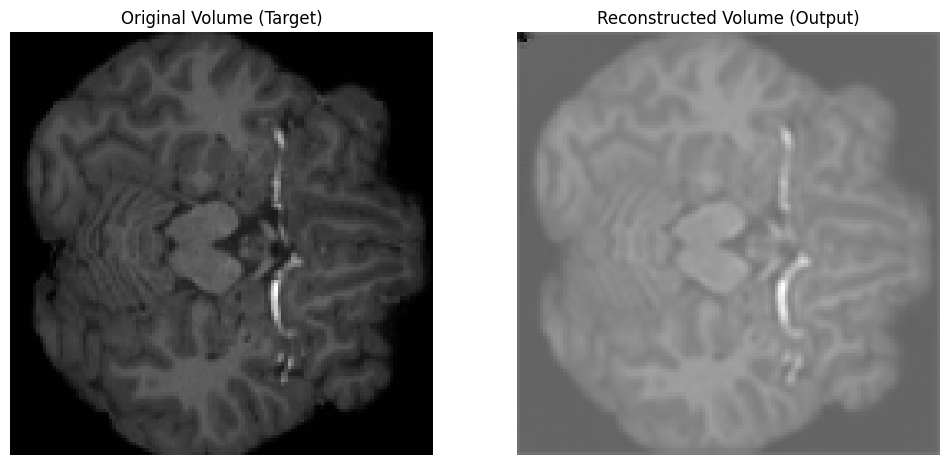

Testing:   3%|▎         | 1/38 [00:00<00:10,  3.51it/s]

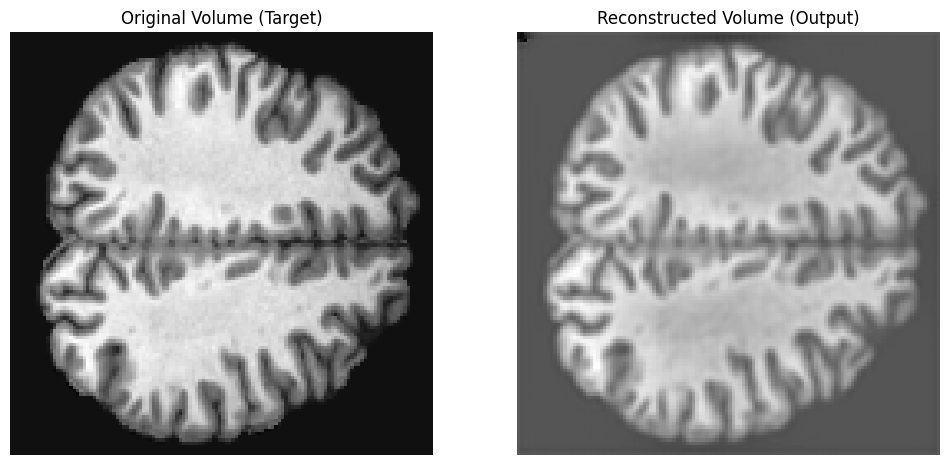

Testing:   5%|▌         | 2/38 [00:00<00:10,  3.51it/s]

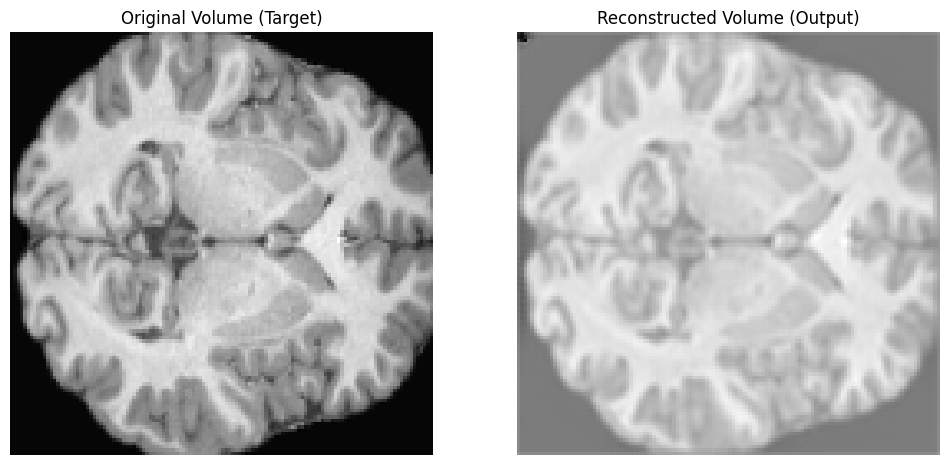

Testing:   8%|▊         | 3/38 [00:00<00:09,  3.51it/s]

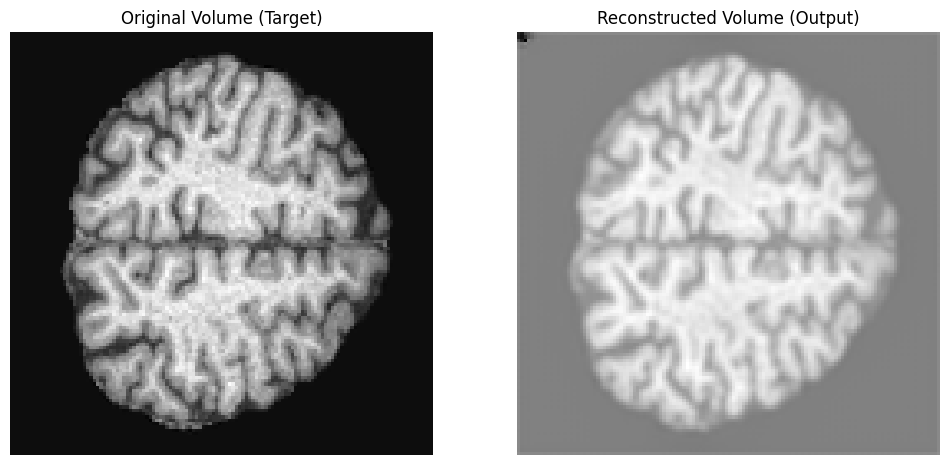

Testing:  11%|█         | 4/38 [00:01<00:09,  3.49it/s]

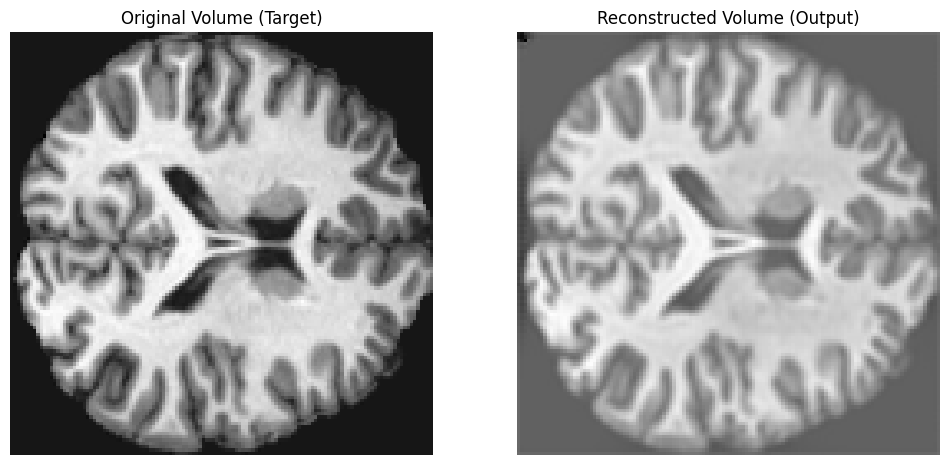

Testing:  13%|█▎        | 5/38 [00:01<00:09,  3.50it/s]

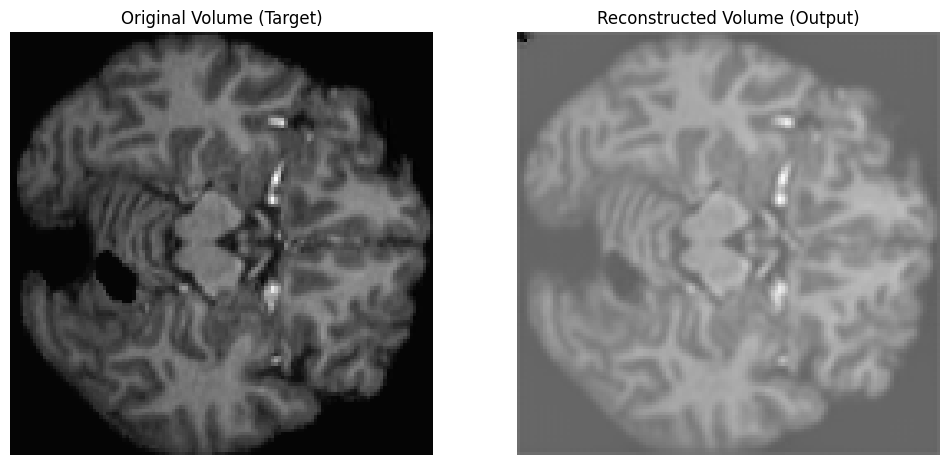

Testing:  16%|█▌        | 6/38 [00:01<00:09,  3.50it/s]

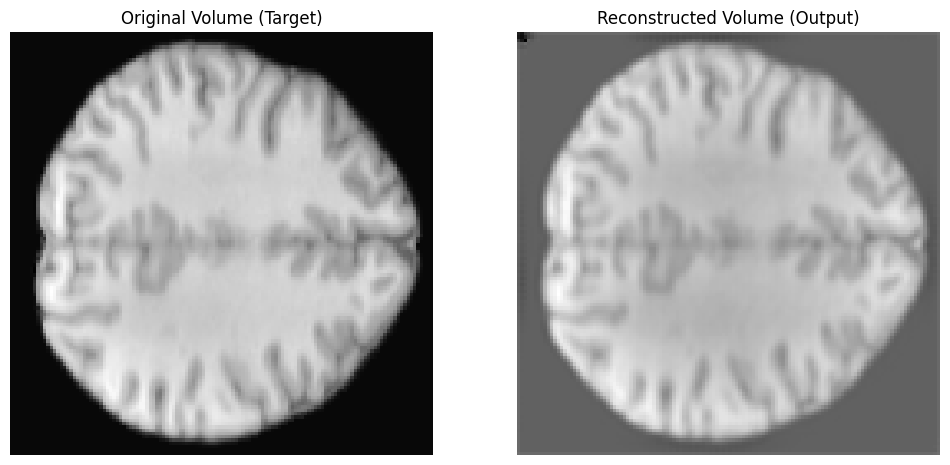

Testing:  18%|█▊        | 7/38 [00:01<00:08,  3.51it/s]

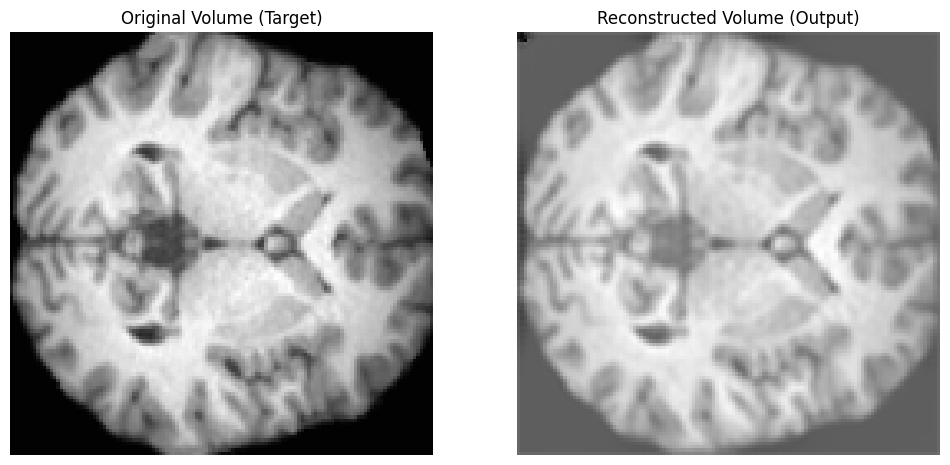

Testing:  21%|██        | 8/38 [00:02<00:08,  3.52it/s]

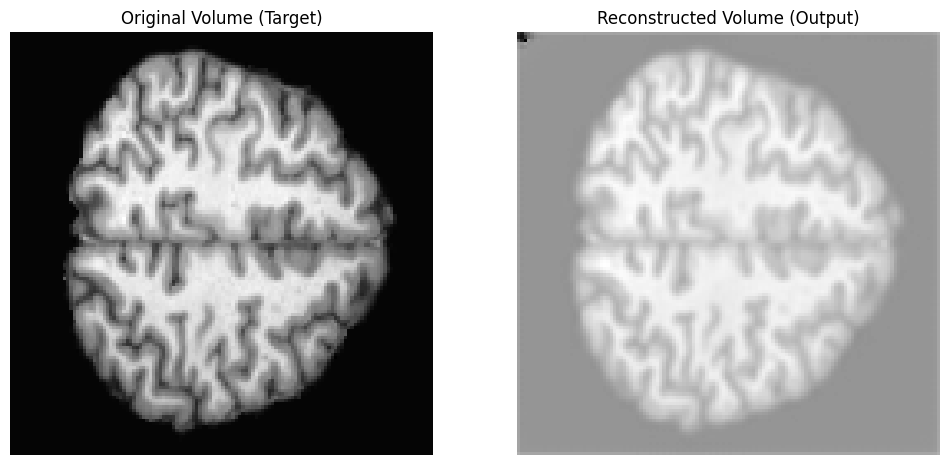

Testing:  24%|██▎       | 9/38 [00:02<00:08,  3.55it/s]

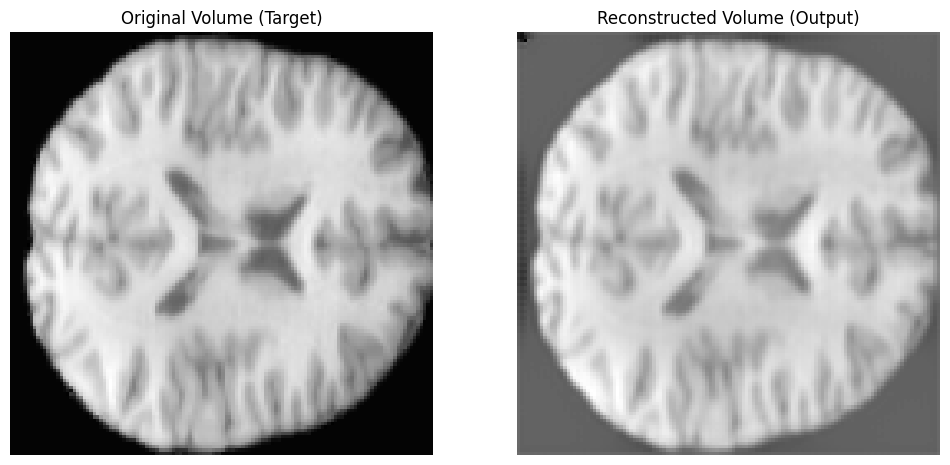

Testing:  26%|██▋       | 10/38 [00:02<00:07,  3.56it/s]

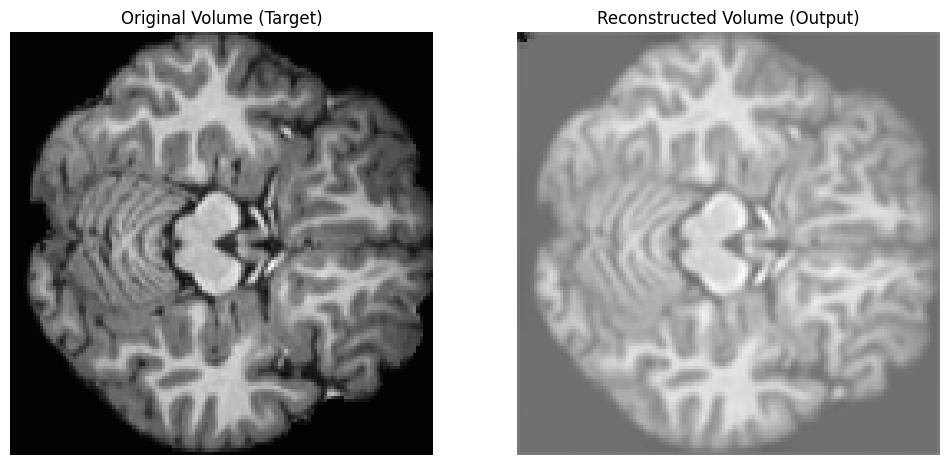

Testing:  29%|██▉       | 11/38 [00:03<00:07,  3.55it/s]

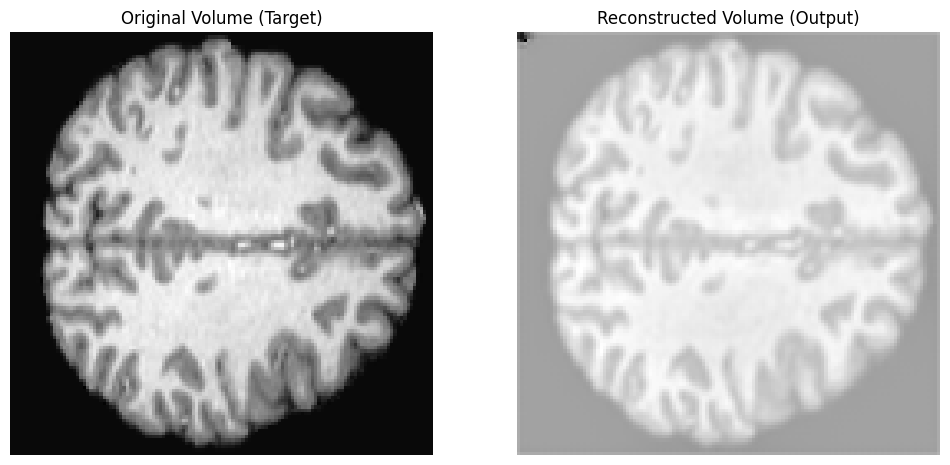

Testing:  32%|███▏      | 12/38 [00:03<00:07,  3.55it/s]

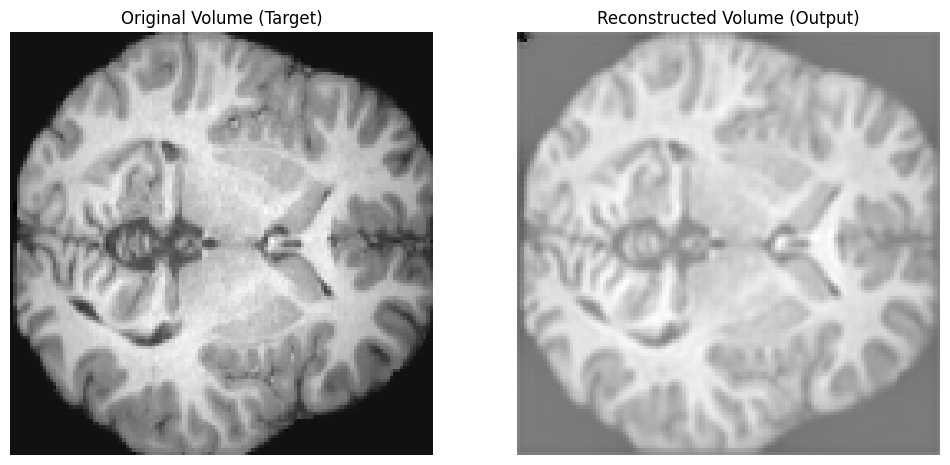

Testing:  34%|███▍      | 13/38 [00:03<00:07,  3.54it/s]

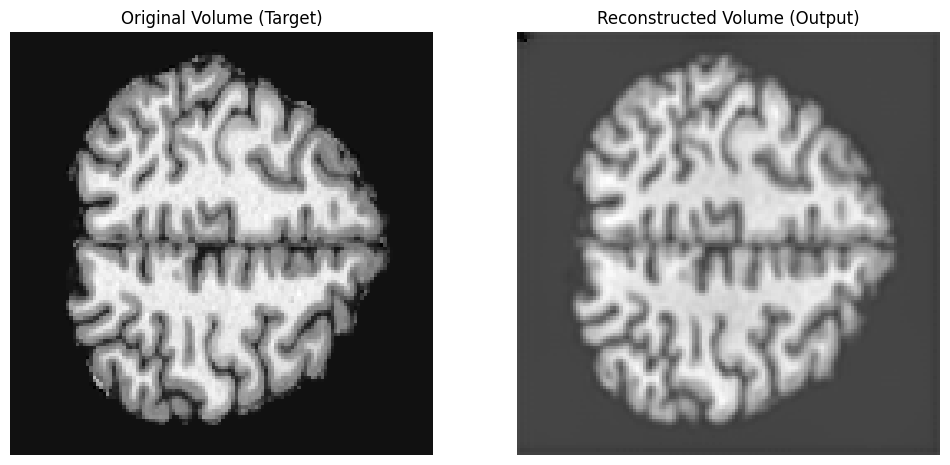

Testing:  37%|███▋      | 14/38 [00:03<00:06,  3.54it/s]

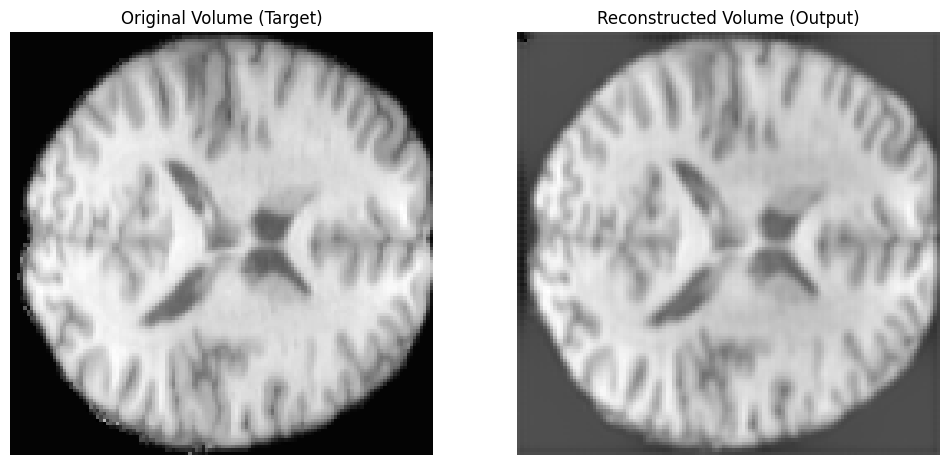

Testing:  39%|███▉      | 15/38 [00:04<00:06,  3.53it/s]

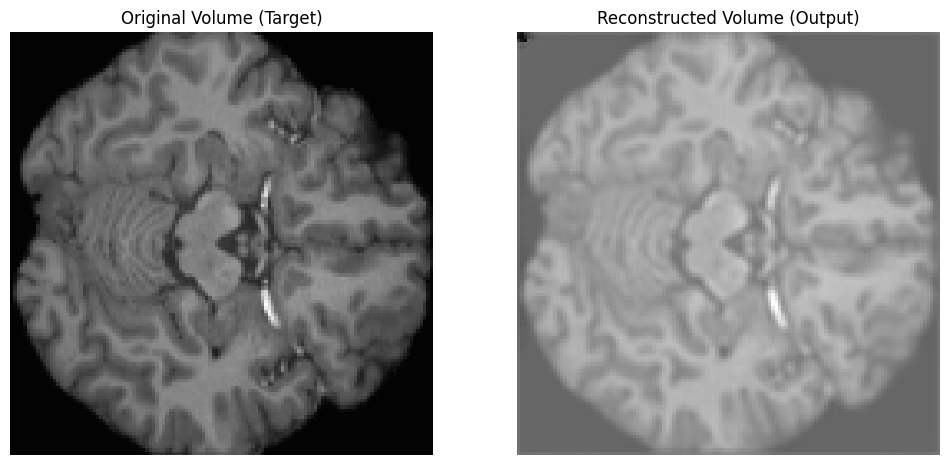

Testing:  42%|████▏     | 16/38 [00:04<00:06,  3.52it/s]

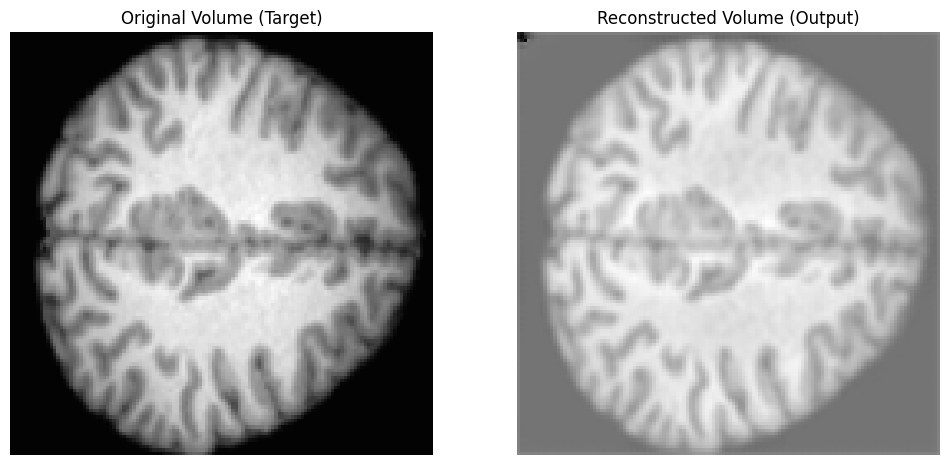

Testing:  45%|████▍     | 17/38 [00:04<00:05,  3.53it/s]

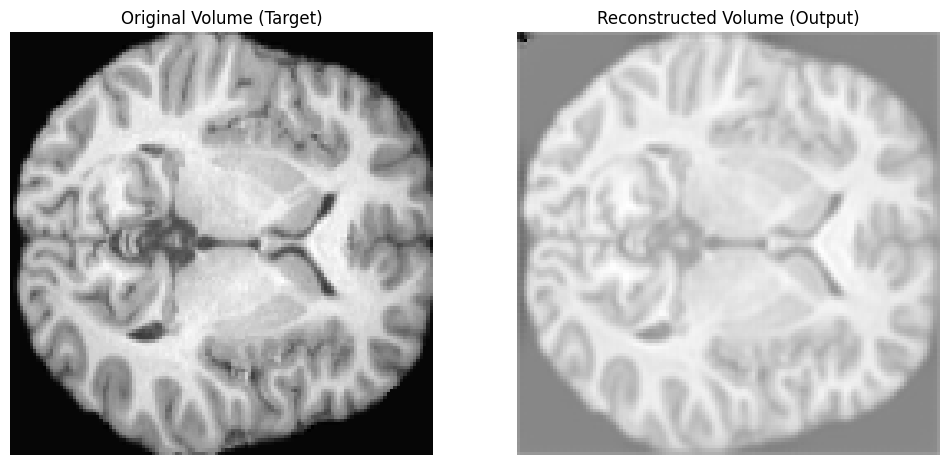

Testing:  47%|████▋     | 18/38 [00:05<00:05,  3.54it/s]

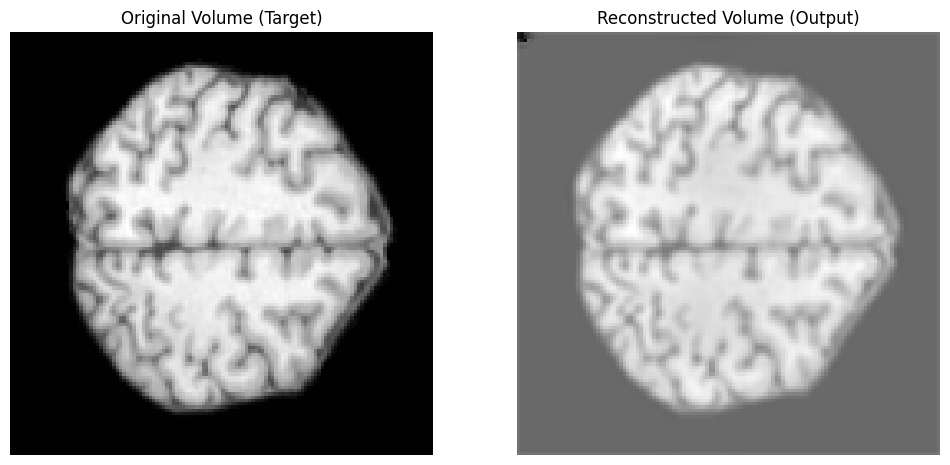

Testing:  50%|█████     | 19/38 [00:05<00:05,  3.54it/s]

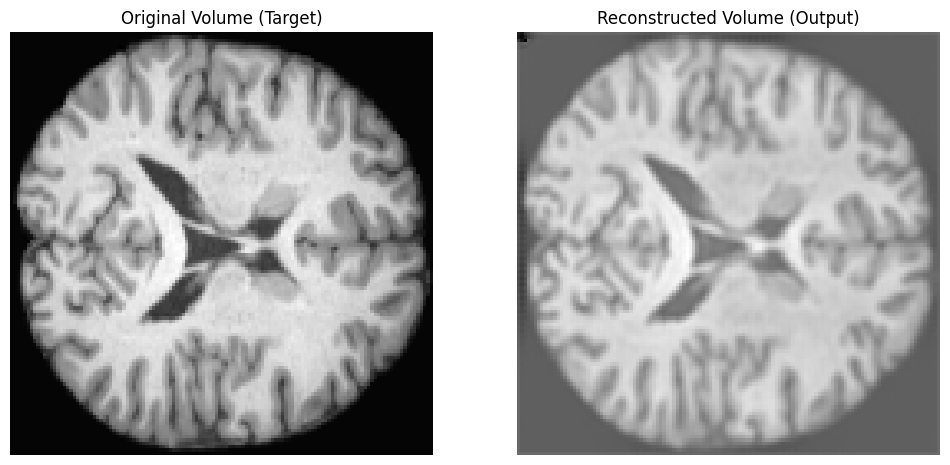

Testing:  53%|█████▎    | 20/38 [00:05<00:05,  3.53it/s]

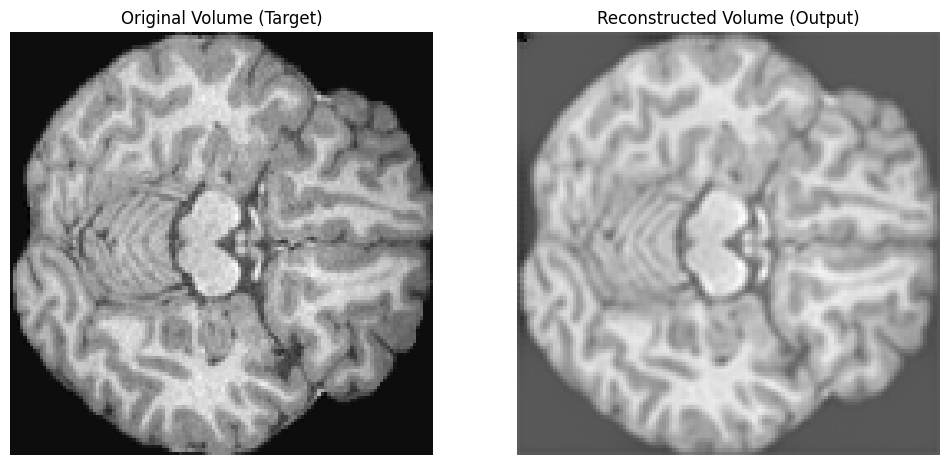

Testing:  55%|█████▌    | 21/38 [00:05<00:04,  3.52it/s]

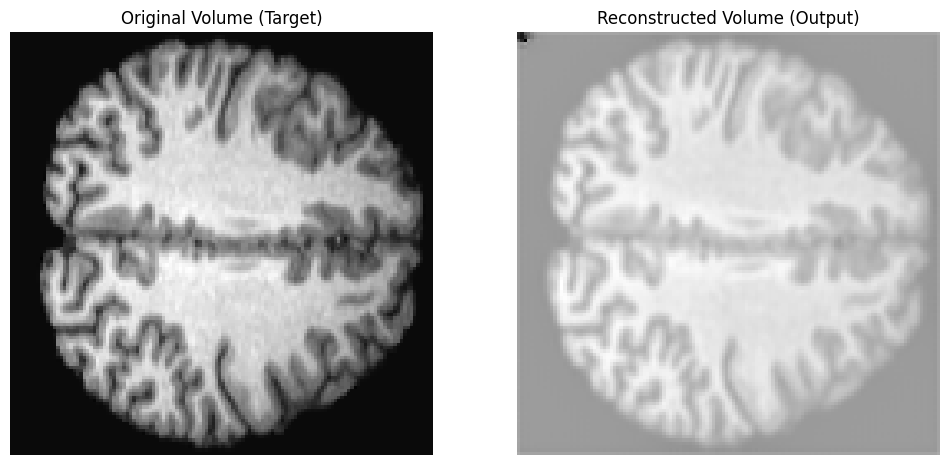

Testing:  58%|█████▊    | 22/38 [00:06<00:04,  3.53it/s]

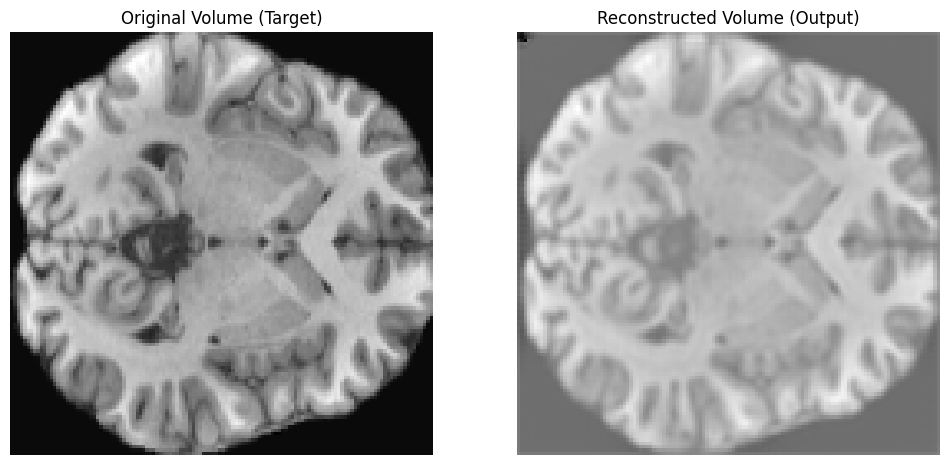

Testing:  61%|██████    | 23/38 [00:06<00:04,  3.53it/s]

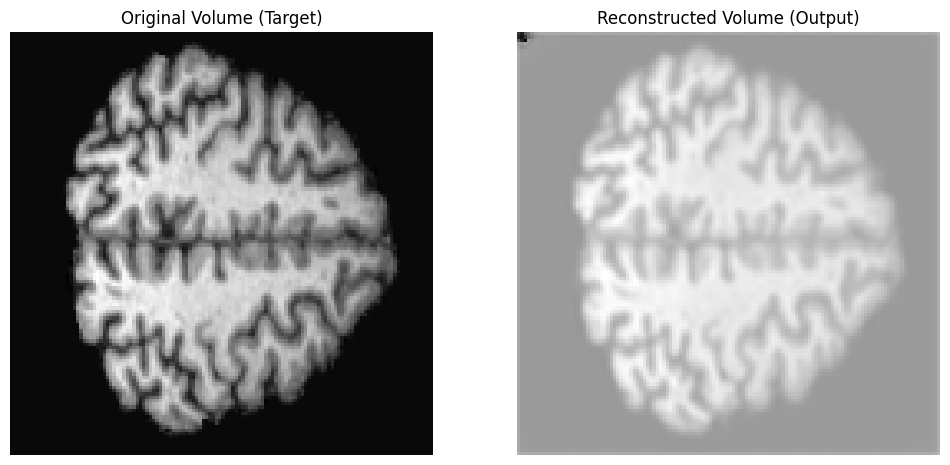

Testing:  63%|██████▎   | 24/38 [00:06<00:03,  3.54it/s]

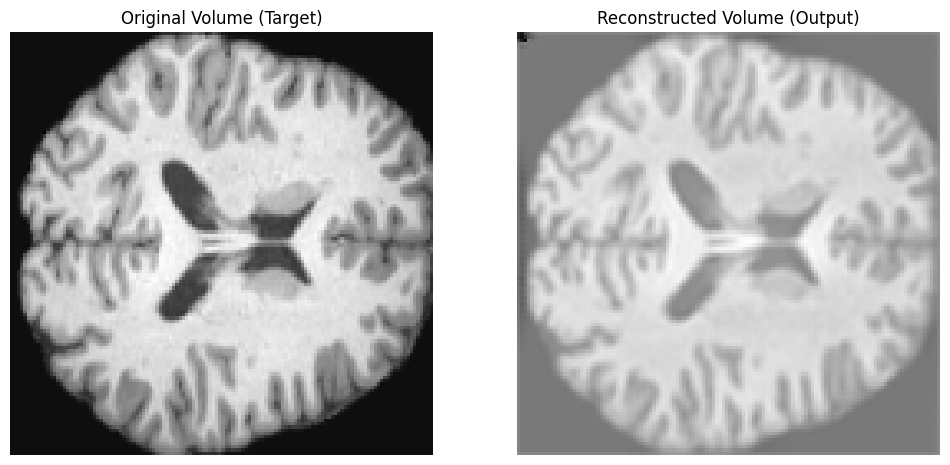

Testing:  66%|██████▌   | 25/38 [00:07<00:03,  3.55it/s]

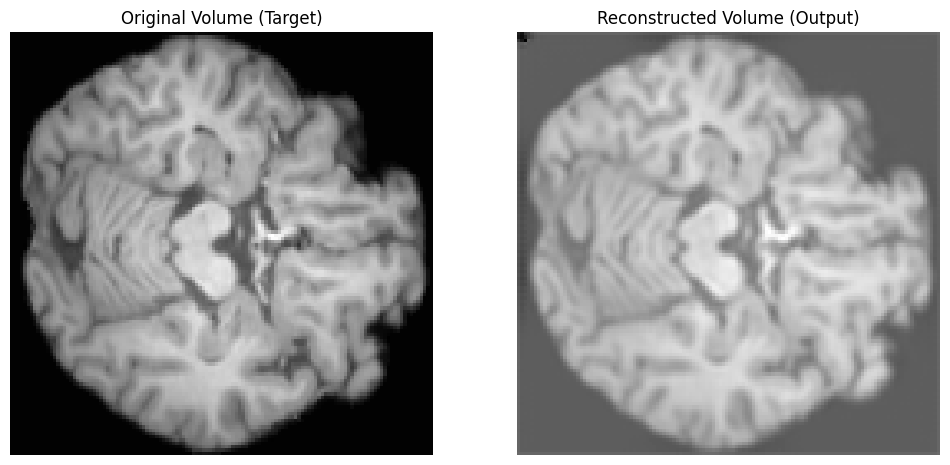

Testing:  68%|██████▊   | 26/38 [00:07<00:03,  3.56it/s]

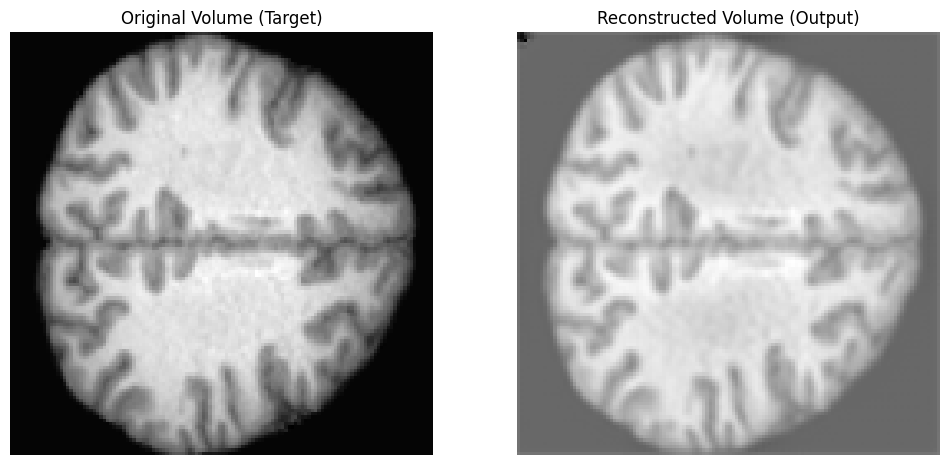

Testing:  71%|███████   | 27/38 [00:07<00:03,  3.56it/s]

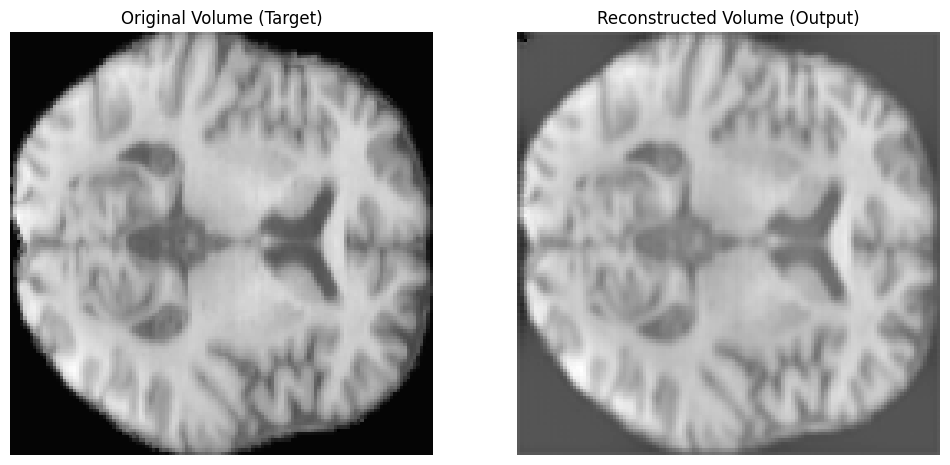

Testing:  74%|███████▎  | 28/38 [00:07<00:02,  3.56it/s]

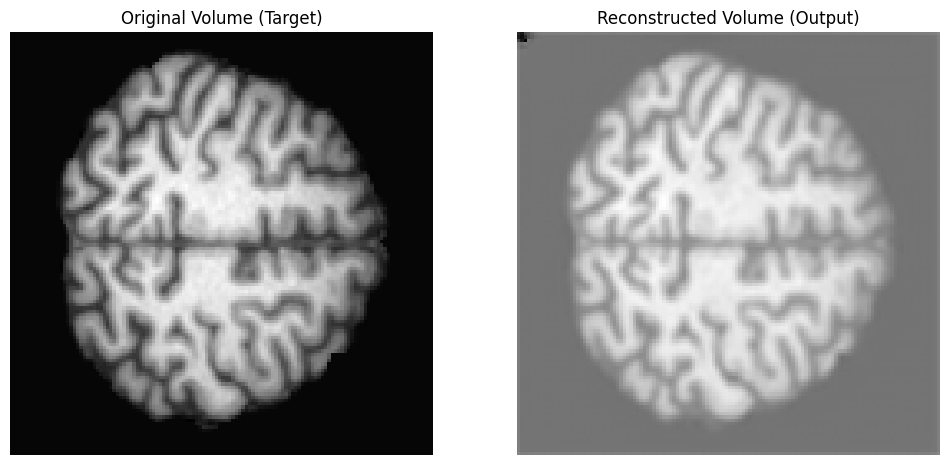

Testing:  76%|███████▋  | 29/38 [00:08<00:02,  3.52it/s]

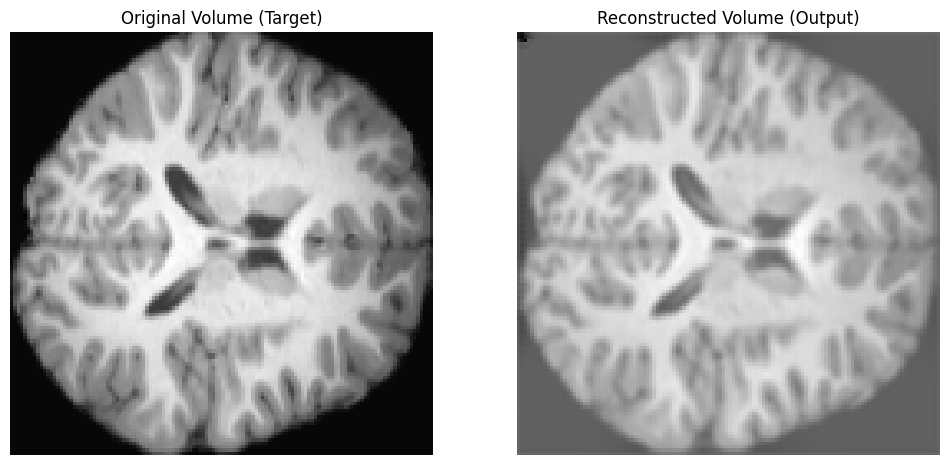

Testing:  79%|███████▉  | 30/38 [00:08<00:02,  3.45it/s]

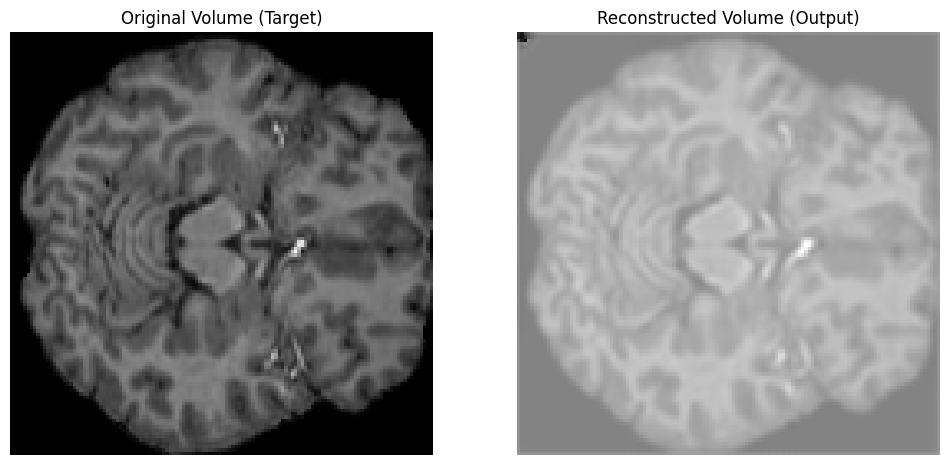

Testing:  82%|████████▏ | 31/38 [00:08<00:02,  3.47it/s]

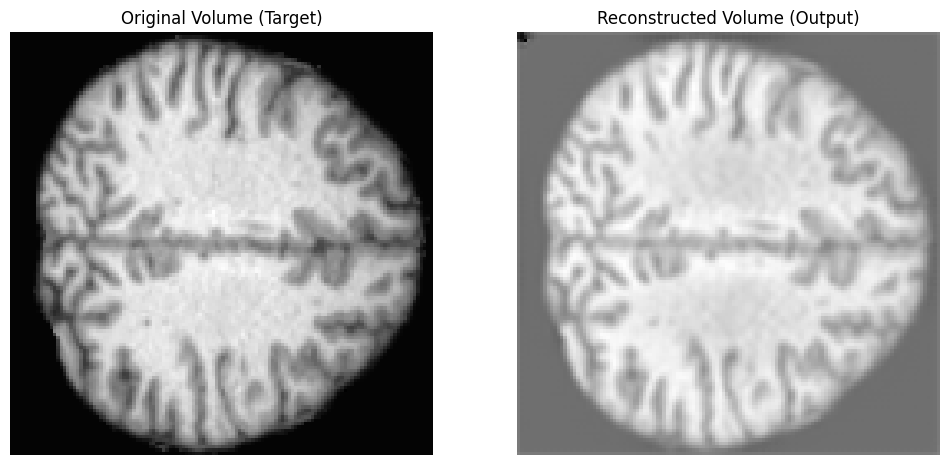

Testing:  84%|████████▍ | 32/38 [00:09<00:01,  3.48it/s]

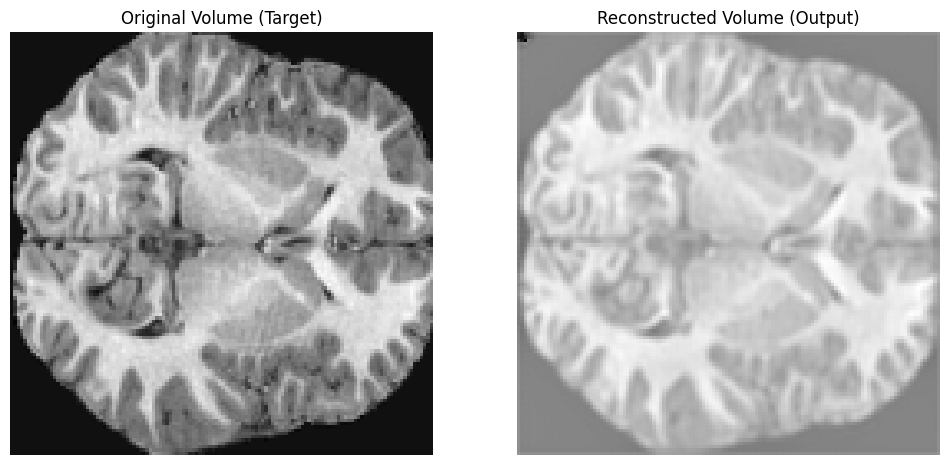

Testing:  87%|████████▋ | 33/38 [00:09<00:01,  3.48it/s]

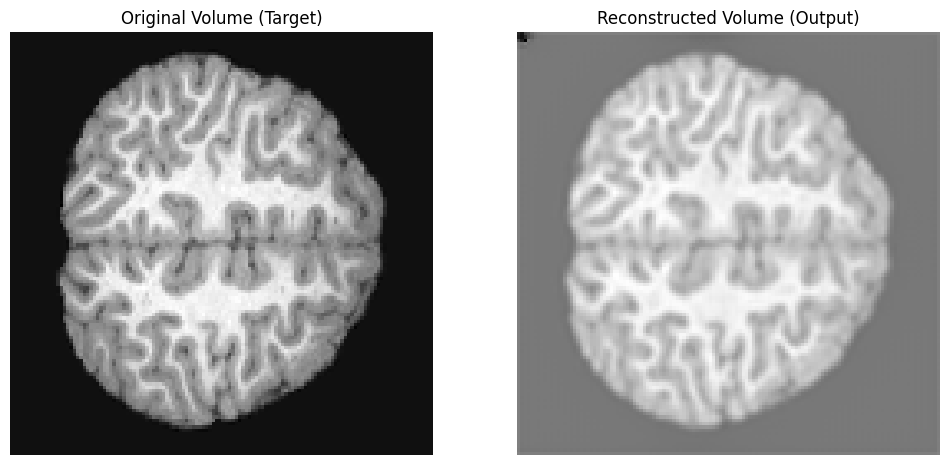

Testing:  89%|████████▉ | 34/38 [00:09<00:01,  3.50it/s]

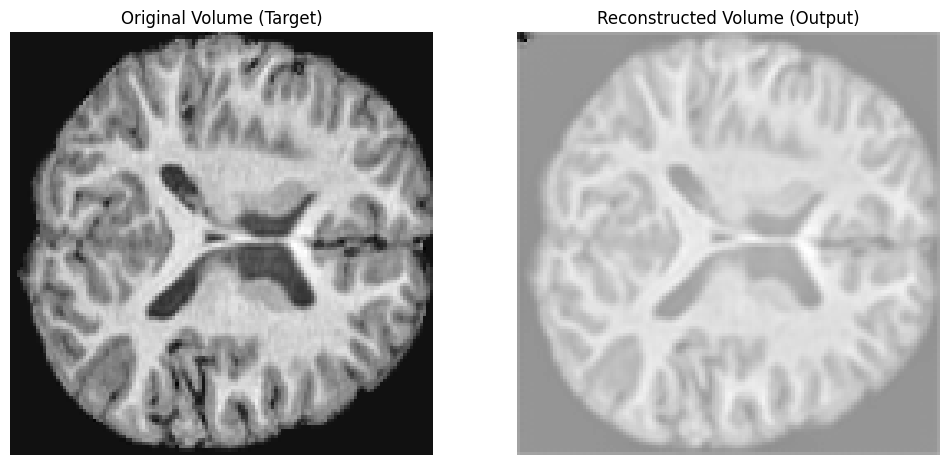

Testing:  92%|█████████▏| 35/38 [00:09<00:00,  3.50it/s]

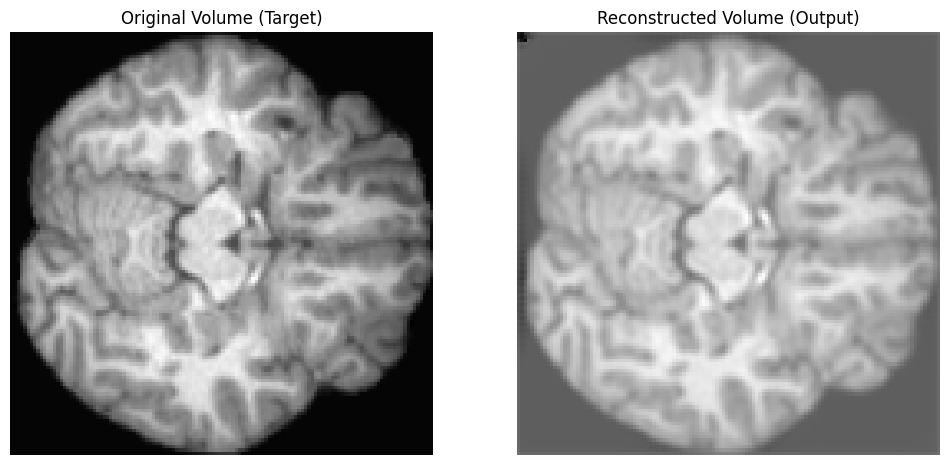

Testing:  95%|█████████▍| 36/38 [00:10<00:00,  3.49it/s]

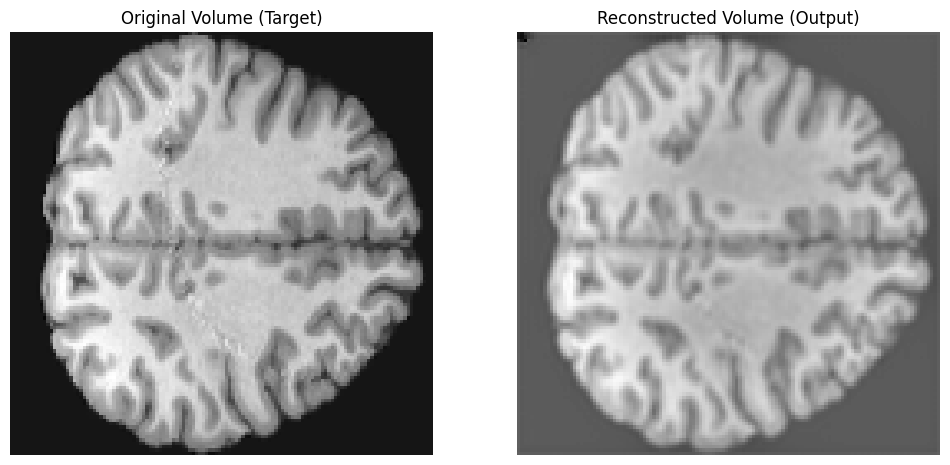

Testing:  97%|█████████▋| 37/38 [00:11<00:00,  1.95it/s]

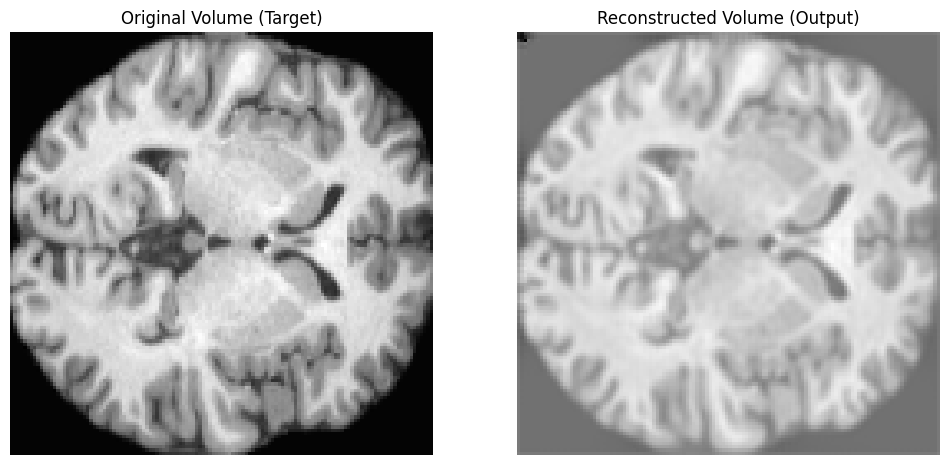

Testing: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]

Average Test Loss: 0.0000


In [45]:
import matplotlib.pyplot as plt
model.eval()
# Test loop
test_loss = 0.0

with torch.no_grad():  # Disable gradient calculations for testing
    for imgs, targets in tqdm(test_loader, desc='Testing'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
        outputs = model(imgs)  # Forward pass
#         loss = criterion(outputs, targets)  # Compute test loss
#         test_loss += loss.item()  # Accumulate test loss

        # Visualize the input and reconstructed volume at depth 8
        depth = 8
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original Volume (Target)
        ax[0].imshow(targets[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Original Volume (Target)')
        ax[0].axis('off')

        # Reconstructed Volume (Output)
        ax[1].imshow(outputs[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Reconstructed Volume (Output)')
        ax[1].axis('off')

        plt.show()  # Display the plot

# Average test loss
test_loss /= len(test_loader)
print(f"Average Test Loss: {test_loss:.4f}")
